### Preparation

and Time Window Selection

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import pandas as pd

### Linear Regression considering only effects of Price shocks

- only consider close prices
- filter the cex data for the 5% of highest candles (in both directions)
- for those price shocks add the dex price 0-12 **blocks** after the CEX shock, which we are trying to predict
- as benchmark we predict DEX Close price by its own DEX Price at the time of the shock, also lag 0 can be considered as benchmark
- 80/20 Train/Test split

In [13]:
nr_of_lags = 22

def prepare(cex, dex):
  df = cex.copy()
  # Calculate the absolute difference between open and close prices for cex
  df['shock_height'] = abs(df['open'] - df['close'])
  df['price_diff'] = df['close'] - df['open']

  # Calculate the 95th percentile of the absolute difference
  threshold = np.percentile(df['shock_height'], 95)

  # Filter rows where the absolute difference is greater than or equal to the threshold
  df_shock = df[df['shock_height'] >= threshold]

  # Drop the 'cex_candle' column as it's no longer needed
  # df_shock = df_shock.drop(columns=['cex_candle'])

  # Create a DataFrame to store the new dataset
  df_new = pd.DataFrame(columns=['shock_timestamp', 'price_diff', 'close_cex'] + [f'lag_before{i}_dex' for i in range(5, 0, -1)] + [f'lag_after{i}_dex' for i in range(1, nr_of_lags)])

  # For each row in the df_shock DataFrame
  for row_num, (index, row) in enumerate(df_shock.iterrows()):
      # If there are at least 6 blocks after the current index

      df_dex_before = dex.loc[:index]
      df_dex_after = dex.loc[index:]

      if len(df_dex_after) > nr_of_lags-1 and len(df_dex_before) > 4:
          # Create a new row
          new_row = {'shock_timestamp': index, 'price_diff': row['price_diff'], 'close_cex': row['close'],}
          # For each lag from 1 to 12
          for i in range(0, nr_of_lags):
              # Add the lagged dex close price to the new row
              if (i > 0 and i < 6):
                new_row[f'lag_before{i}_dex'] = df_dex_before.iloc[i*-1]['price']
              new_row[f'lag_after{i+1}_dex'] = df_dex_after.iloc[i]['price']
          # Append the new row to the new DataFrame
          df_new = pd.concat([df_new, pd.DataFrame([new_row])], ignore_index=True)


  df_new = df_new.set_index('shock_timestamp')
  return df_new

### Same with Cross Validation

In [15]:
def regress(df_new):
  df = df_new.copy()
  # Define the models
  models = [
      ('Linear Regression', LinearRegression()),
      # ('SVM', SVR()),
      # ('KNN', KNeighborsRegressor())
  ]

  # Create a DataFrame to store the results
  # results = pd.DataFrame(columns=['Model', 'Lag', 'Test RMSE', 'Test R2', 'Test RMSE Benchmark', 'Test R2 Benchmark'])
  results = pd.DataFrame(columns=['Lag', 'Test RMSE', 'Test RMSE Benchmark'])
  cv = KFold(n_splits=10, random_state=1, shuffle=True)

  # For each number of lags
  for l in range(1, nr_of_lags+1):

    # For each model
    for name, model in models:

      # Train on cex to predict dex
      X = df[['close_cex']]
      y = df[f'lag_after{l}_dex']
      rmse_scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
      rmse_scores = -rmse_scores  # flip the sign to make MSE positive
      # r2_scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)

      # Train on dex to predict dex
      X_dex = df_new.iloc[:,(l+1):(l+5)]
      y_dex = df[f'lag_after{l}_dex']
      dex_rmse_scores = cross_val_score(model, X_dex, y_dex, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
      dex_rmse_scores = -dex_rmse_scores  # flip the sign to make MSE positive
      # dex_r2_scores = cross_val_score(model, X_dex, y_dex, scoring='r2', cv=cv, n_jobs=-1)

      # new_row = pd.DataFrame({'Model': [name], 'Lag': [l], 'Test RMSE': ['%.3f' % (np.mean(rmse_scores))],'Test R2': ['%.3f' % (np.mean(r2_scores))], 'Test RMSE Benchmark': ['%.3f' % (np.mean(dex_rmse_scores))],'Test R2 Benchmark': ['%.3f' % (np.mean(dex_r2_scores))]})
      new_row = pd.DataFrame({'Lag': [l], 'Test RMSE': np.mean(rmse_scores),'Test RMSE Benchmark': np.mean(dex_rmse_scores)})
      
      results = pd.concat([results, new_row], ignore_index=True)

  # Display the results
  return results

In [20]:
# asset = "UNI/USDT"
# dex = pd.read_pickle("datasets/dex_UNI_USDC_2022_allblocks.pkl")
# cex = pd.read_pickle("datasets/cex_UNI_USDT_2022.pkl")
# asset = "BTC/USDT"
# dex = pd.read_pickle("datasets/dex_WBTC_USDT_2022_allblocks.pkl")
# cex = pd.read_pickle("datasets/cex_BTC_USDT_2022.pkl")
# asset = "ETH/USDT"
# dex = pd.read_pickle("datasets/dex_WETH_USDT_2022_allblocks.pkl")
# cex = pd.read_pickle("datasets/cex_ETH_USDT_2022.pkl")
asset = "SHIB/USDT"
dex = pd.read_pickle("datasets/dex_SHIB_USDT_2022_allblocks.pkl")
cex = pd.read_pickle("datasets/cex_SHIB_USDT_2022.pkl")


# This creates a dictionary of dataframes, where each key is the start date of the week
cex_weekly = {str(week_start_date.date()): group for week_start_date, group in cex.groupby(pd.Grouper(freq='W'))}
dex_weekly = {str(week_start_date.date()): group for week_start_date, group in dex.groupby(pd.Grouper(freq='W'))}
results = pd.DataFrame()
best_lags = pd.DataFrame(columns=['Week', 'best_lag', 'rsme', 'bmrsme'])
i = 0

for week_start_date, cex_df in cex_weekly.items():
    print(f"Week ending on: {week_start_date}")

    dex_df = dex_weekly[week_start_date]

    if (dex_df['price'].isnull().any()):
      print(f"Skipping Week because of empty values")
    else:
      df = prepare(cex_df,dex_df)
      result = regress(df)

      results[f'RMSE {i}'] = result[f'Test RMSE']
      results[f'RMSE BM {i}'] = result[f'Test RMSE Benchmark']

      best_index = result['Test RMSE'].idxmin()
      new_row = pd.DataFrame([{'Week': week_start_date, 'best_lag': best_index + 1, 'rsme': result['Test RMSE'].iloc[best_index], 'bmrsme': result['Test RMSE Benchmark'].iloc[best_index]}])
      best_lags = pd.concat([best_lags, new_row], ignore_index=True)

    i += 1

results.insert(0,'block_lag',results.index + 1)

display(best_lags)

Week ending on: 2022-01-02
Skipping Week because of empty values
Week ending on: 2022-01-09
Week ending on: 2022-01-16
Week ending on: 2022-01-23
Week ending on: 2022-01-30
Week ending on: 2022-02-06
Week ending on: 2022-02-13
Week ending on: 2022-02-20
Week ending on: 2022-02-27
Week ending on: 2022-03-06
Week ending on: 2022-03-13
Week ending on: 2022-03-20
Week ending on: 2022-03-27
Week ending on: 2022-04-03
Week ending on: 2022-04-10
Week ending on: 2022-04-17
Week ending on: 2022-04-24
Week ending on: 2022-05-01
Week ending on: 2022-05-08
Week ending on: 2022-05-15
Week ending on: 2022-05-22
Week ending on: 2022-05-29
Week ending on: 2022-06-05
Week ending on: 2022-06-12
Week ending on: 2022-06-19
Week ending on: 2022-06-26
Week ending on: 2022-07-03
Week ending on: 2022-07-10
Week ending on: 2022-07-17
Week ending on: 2022-07-24
Week ending on: 2022-07-31
Week ending on: 2022-08-07
Week ending on: 2022-08-14
Week ending on: 2022-08-21
Week ending on: 2022-08-28
Week ending on: 2

/tmp/ipykernel_1176/183392155.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results[f'RMSE {i}'] = result[f'Test RMSE']
/tmp/ipykernel_1176/183392155.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results[f'RMSE BM {i}'] = result[f'Test RMSE Benchmark']


Week ending on: 2023-01-01


/tmp/ipykernel_1176/183392155.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results[f'RMSE {i}'] = result[f'Test RMSE']
/tmp/ipykernel_1176/183392155.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results[f'RMSE BM {i}'] = result[f'Test RMSE Benchmark']
/tmp/ipykernel_1176/183392155.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

,Week,best_lag,rsme,bmrsme
0,2022-01-09,21,0.159678,0.022569
1,2022-01-16,21,0.158839,0.011802
2,2022-01-23,22,0.140626,0.014578
3,2022-01-30,22,0.160919,0.001541
4,2022-02-06,22,0.113524,0.010960
5,2022-02-13,21,0.077265,0.006154
6,2022-02-20,21,0.090383,0.004508
7,2022-02-27,22,0.174954,0.006420
8,2022-03-06,19,0.068453,0.005644
9,2022-03-13,22,0.116056,0.002328


In [21]:
result

,Lag,Test RMSE,Test RMSE Benchmark
0,1,0.020427,0.002452
1,2,0.019622,0.003367
2,3,0.019059,0.004705
3,4,0.018603,0.004216
4,5,0.018140,0.003354
5,6,0.017940,0.002687
6,7,0.017432,0.003294
7,8,0.017333,0.003345
8,9,0.017139,0.001672
9,10,0.017094,0.001360


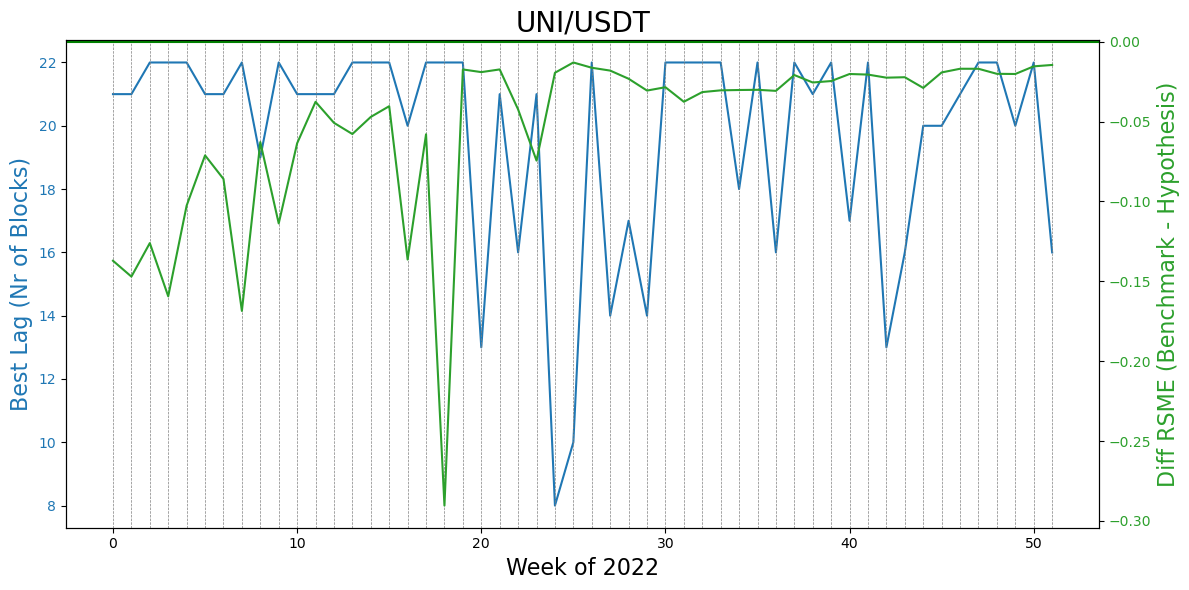

In [22]:
df = best_lags.copy()
df['bench_diff_rsme'] = df['bmrsme'] - df['rsme']

fig, ax1 = plt.subplots(figsize=(12, 6))

# plot 'best_lag' on the first y-axis
ax1.plot(df.index, df['best_lag'], color='tab:blue')
ax1.set_ylabel('Best Lag (Nr of Blocks)', color='tab:blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xlabel('Week of 2022', fontsize=16) 

for x in df.index:
    ax1.axvline(x, color='gray', linestyle='--', linewidth=0.5)

# instantiate a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# plot 'bench_diff_rsme' on the second y-axis
ax2.plot(df.index, df['bench_diff_rsme'], color='tab:green')
ax2.set_ylabel('Diff RSME (Benchmark - Hypothesis)', color='tab:green', fontsize=16)
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.axhline(0, color='green')

ax1.set_title(asset, fontsize=20)

fig.tight_layout()  # ensure right y-label is not clipped
plt.show()

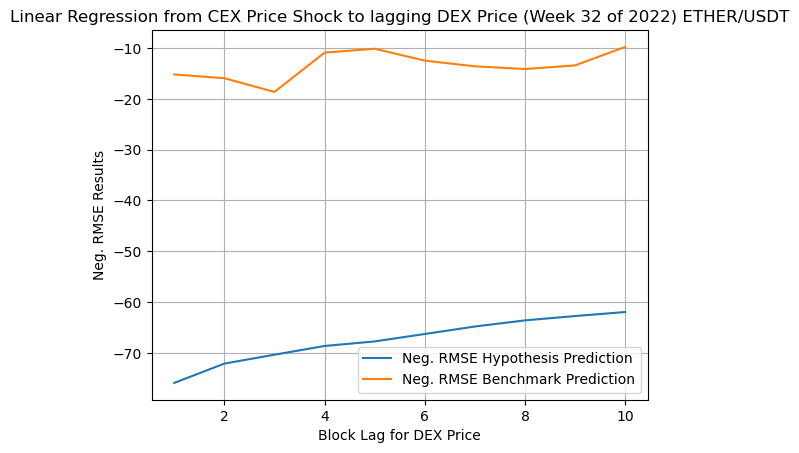

In [7]:
plt.plot(results['block_lag'], results['RMSE 31']*-1, label='Neg. RMSE Hypothesis Prediction')
plt.plot(results['block_lag'], results['RMSE BM 31']*-1, label='Neg. RMSE Benchmark Prediction')

# To have a grid in your plot
plt.grid(True)

# Labeling the axes
plt.xlabel('Block Lag for DEX Price')
plt.ylabel('Neg. RMSE Results')

# Adding the legend
plt.legend()
plt.title('Linear Regression from CEX Price Shock to lagging DEX Price (Week 32 of 2022) ETHER/USDT')

# Displaying the plot
plt.show()

In [66]:
shocks = pd.DataFrame()
i = 0

for week_start_date, cex_df in cex_weekly.items():
    # print(f"Week starting on: {week_start_date}")
    # if len(results) == 0:
    #   results = result

    df = cex_df.copy()
    # Calculate the absolute difference between open and close prices for cex
    df['shock_height'] = abs(df['open'] - df['close'])
    df['price_diff'] = df['close'] - df['open']

    # Calculate the 95th percentile of the absolute difference
    threshold = np.percentile(df['shock_height'], 95)

    # Filter rows where the absolute difference is greater than or equal to the threshold
    df_shock = df[df['shock_height'] >= threshold]
    df_shock = df_shock.reset_index(drop=True)
    print(len(df_shock))

    shocks = pd.concat([shocks,df_shock['price_diff'].rename(f'{i}')], axis=1)

    i += 1

shocks

145
505
509
506
505
506
505
506
506
506
505
505
506
507
505
505
506
506
506
505
507
505
507
506
505
509
508
507
505
505
507
505
507
505
505
506
511
510
506
505
505
508
508
506
509
505
507
513
509
510
508
508
457


,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,8.62,9.01,6.04,-19.31,-7.73,-7.57,-7.32,6.60,8.71,-8.40,...,-3.71,-2.69,-5.94,3.76,-3.14,-1.71,1.64,-1.48,1.52,1.45
1,6.70,7.76,-6.25,-10.37,-9.01,-10.68,-9.84,-5.96,10.18,-7.15,...,-3.01,2.71,-6.27,2.31,-3.14,-1.96,-1.60,-1.61,1.36,-0.96
2,8.52,8.78,9.13,9.32,-8.90,-8.15,-10.61,6.43,14.78,12.36,...,-3.52,-3.76,6.27,2.97,-4.14,1.70,-1.30,1.66,1.66,0.93
3,6.57,7.16,5.93,14.06,-11.54,-6.81,6.72,-6.06,8.87,-7.44,...,-4.47,-2.72,-6.47,-4.12,1.91,-3.65,-1.31,-1.52,1.24,0.91
4,-6.79,9.75,-6.01,8.63,-7.86,-6.49,-6.78,5.98,8.50,-6.41,...,-3.66,4.37,-8.54,-25.94,-2.50,-2.38,1.56,1.65,1.56,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,NaN,NaN,-8.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-2.93,NaN,NaN,-2.23,1.99,-1.36,NaN,NaN,NaN
509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-3.12,NaN,1.49,NaN,NaN,NaN
510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.49,NaN,NaN,NaN,NaN,NaN
511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.22,NaN,NaN,NaN,NaN,NaN


/home/collins/miniconda3/envs/caa_statistics/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


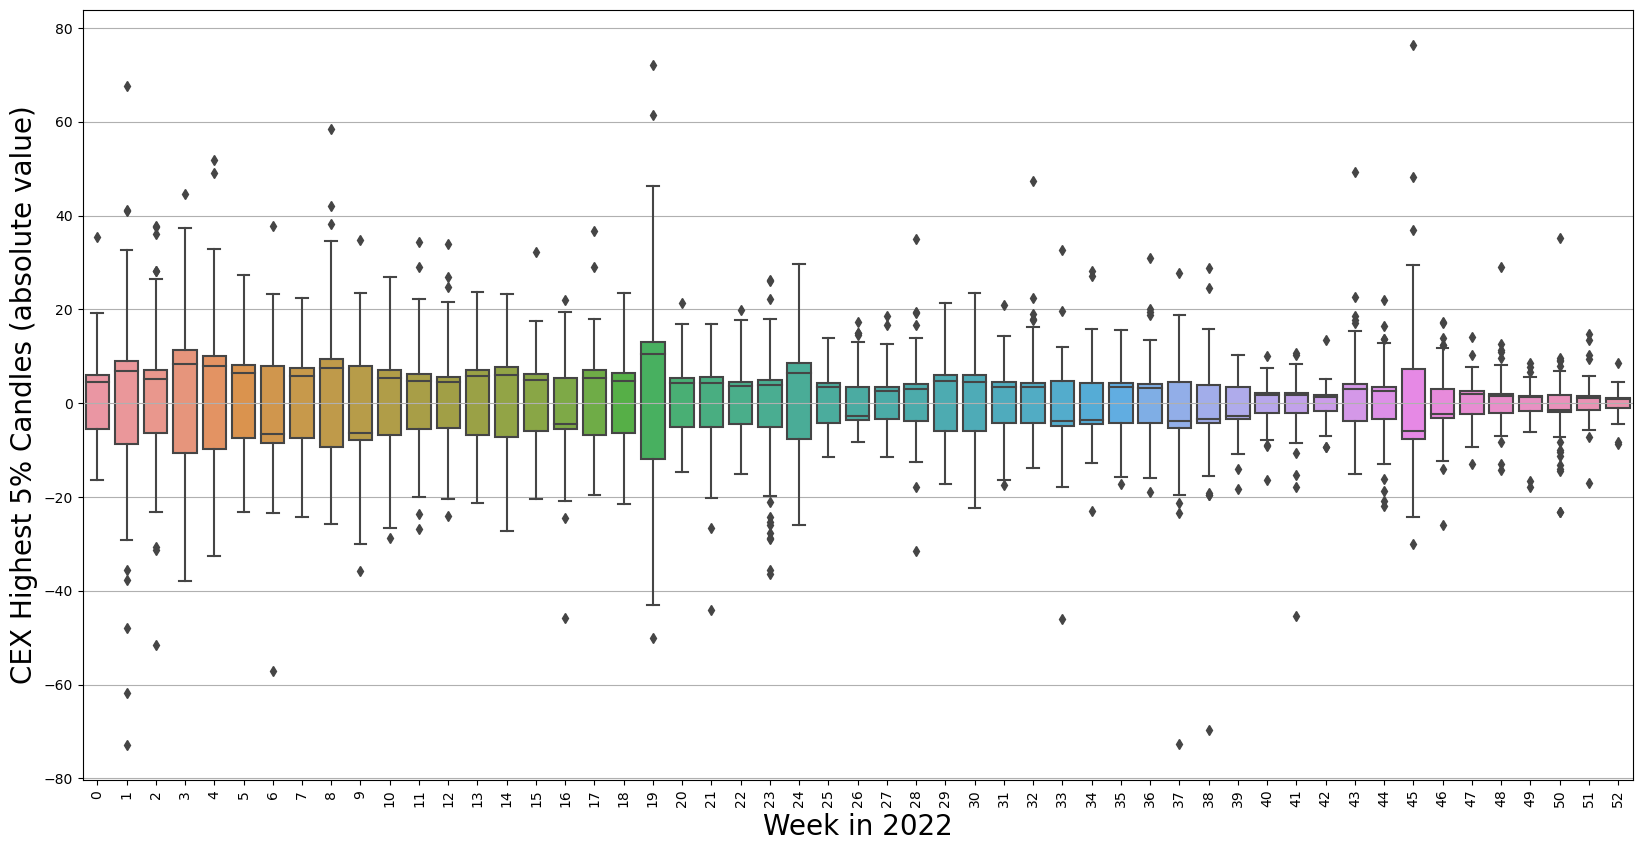

In [73]:
import seaborn as sns
plt.figure(figsize=(20,10))

# plot boxplot with seaborn
sns.boxplot(data=shocks)

# Rotate x-labels for better visibility if they overlap
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.ylabel('CEX Highest 5% Candles (absolute value)', fontsize=20)
plt.xlabel('Week in 2022', fontsize=20)

# Show the plot
plt.show()